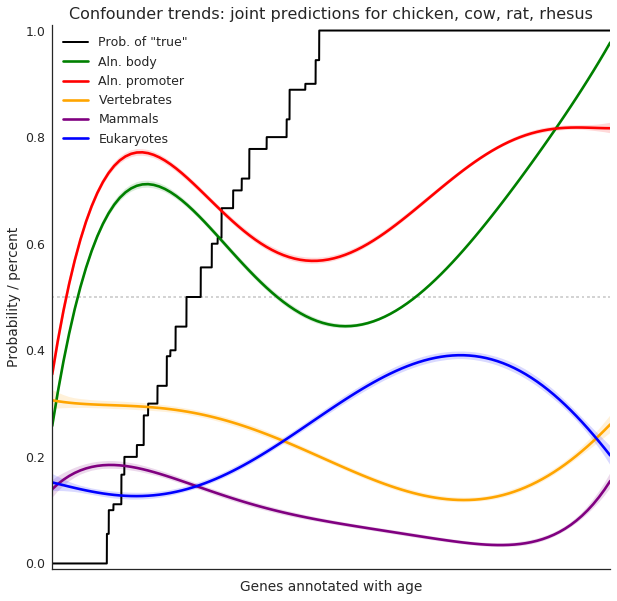

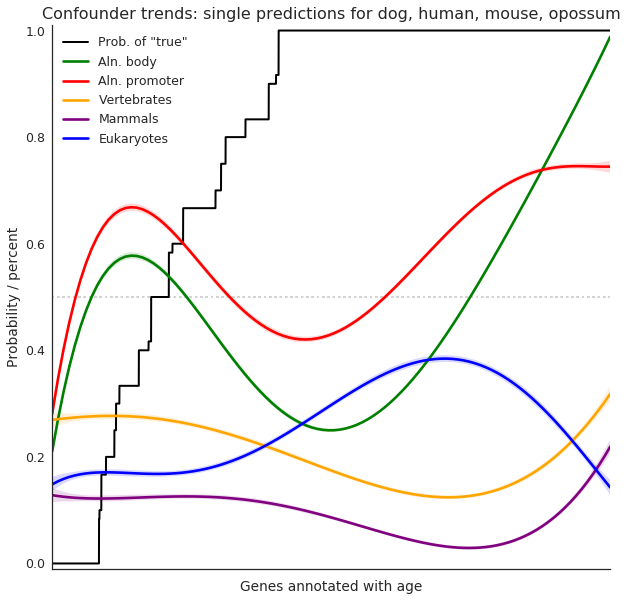

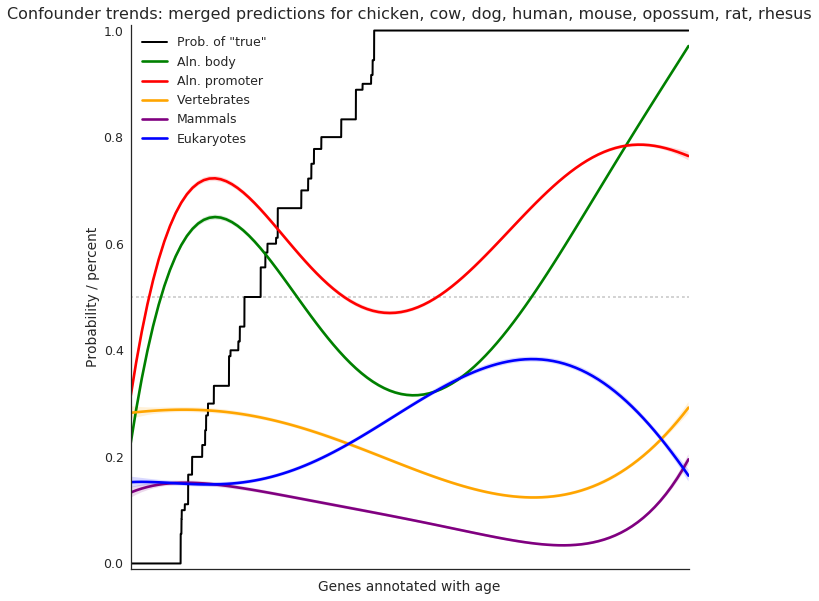

Gene age plot created


In [2]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import spearmanr as spr

from sklearn.metrics import accuracy_score

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
model_file = os.path.join(fhgfs_base, 'refdata/geneage/model', 'RFreg_cv_train.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')


run_exec_age_feat = True

show_figures = True
save_figures = True
out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'


gene_ages = [('Eumetazoa', 948), ('Eukaryota', 2100),
             ('Vertebrata', 615), ('Opisthokonta', 1105),
             ('Mammalia', 177), ('Euk./Bac.', 3500),
             ('Euk./Arch.', 3000), ('Cell. org.', 4200)]

age_labels = {'Eumetazoa': 948, 'Eukaryota': 2100,
              'Vertebrata': 615, 'Opisthokonta': 1105,
              'Mammalia': 177, 'Euk./Bac.': '?',
              'Euk./Arch.': '?', 'Cell. org.': 4200}

group_labels = {'ftage_bin_eumeta': 'Eumetazoa', 'ftage_bin_euk': 'Eukaryota',
                'ftage_bin_vert': 'Vertebrata', 'ftage_bin_opist': 'Opisthokonta',
                'ftage_bin_mamm': 'Mammalia', 'ftage_bin_eukbac': 'Euk./Bac.',
                'ftage_bin_eukarch': 'Euk./Arch.', 'ftage_bin_cellorg': 'Cell. org.'}

def exec_age_feat():
    
    for setting in ['joint', 'single', 'merged']:
        with pd.HDFStore(model_file, 'r') as hdf:
            # merge target estimates for OOB and actual test samples
            oob_est = hdf['/both/{}/oob'.format(setting)]
            test_est = hdf['/both/{}/test'.format(setting)]
            mrg_est = pd.concat([oob_est, test_est], axis=1, ignore_index=True)
            # average across all to get final estimate
            mrg_est.replace(-1, np.nan, inplace=True)
            mrg_est = mrg_est.mean(axis=1, numeric_only=True)
            assert not pd.isnull(mrg_est).any()
            
            perf = hdf['/both/{}/perf'.format(setting)]
            data = hdf['/both/{}/data'.format(setting)]
            data.index = data['name']
            queries = ', '.join(sorted(data['species'].unique()))
            data['prediction'] = mrg_est
            data.sort_values(['target', 'prediction'], axis=0, ascending=True, inplace=True)
            
            feat = ['target', 'ftcons_pct_body', 'ftcons_pct_reg5p',
                    'ftage_abs_vert', 'ftage_abs_mamm', 'ftage_abs_euk']
            colors = ['black', 'green', 'red', 'orange', 'purple', 'blue']
            labels = ['Prob. of "true"', 'Aln. body', 'Aln. promoter',
                      'Vertebrates', 'Mammals', 'Eukaryotes']
    
            data.sort_values(feat, axis=0, ascending=True, inplace=True)
            
            title = 'Confounder trends: {} predictions for {}'.format(setting, queries)
            fig, exart = plot_feature_trends(data, feat, colors, labels, title)

            if save_figures:
                outpath = os.path.join(out_folder, 'main', 'fig_X_supp_confounder_{}.svg'.format(setting))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True


def plot_feature_trends(df, features, colors, labels, title):
    """
    """
    x_vals = np.arange(df.shape[0])
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim(-0.01, x_vals.max() + 0.01)
    ax.set_ylim(-0.01, 1.01)
    for ft, c, l in zip(features, colors, labels):
        col_data = df[ft]
        if ft == 'ftconf_abs_nodeerror':
            col_data = np.log2(1 + col_data)
            col_data += col_data.min()
            col_data /= col_data.max()
        if ft != 'target' and 'ftcons' in ft:
            col_data /= 100
            col_data = col_data.round(2)
        if ft == 'target':
            ax.plot(x_vals, col_data.values, label=l, color=c, lw=2, ls='solid',
                    zorder=2)
        else:
            sns.regplot(x_vals, col_data, lowess=False, robust=False,
                        scatter=False, ax=ax, fit_reg=True, label=l, color=c,
                        order=5, x_ci='sd')
        ax.axhline(0.5, 0, 1, color='lightgrey', lw=2, ls='dotted', zorder=1)
        ax.legend()
        ax.set_ylabel('Probability / percent')
        ax.set_xlabel('Genes annotated with age')
        ax.set_xticklabels([])
        ax.set_title(title, fontsize=16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    if show_figures:
        plt.show()
        
    return fig, []
   
    
if run_exec_age_feat:
    execd = exec_age_feat()
    print('Gene age plot created')